# **Bus Need Classifier Preprocessing V3**

*Updates from V2: cleaned up numerical values (outliers) and dropped some more categorical columns; removed heavy rail distinction among columns. Also tested logreg and random forest on cleaned data.*

This notebook is for preprocessing data from the 2022 National Household Travel Survey to train a classifier. The classifier will be able to identify whether a given student needs a school bus or not based on basic demographic information maintained by a school as well as information that can be derived from the student's address.

The codebook used for translating the survey's encodings can be found here: https://nhts.ornl.gov/assets/2022/doc/codebook.pdf

The User Guide for interpreting survey data (including instructions on merging dataframes) can be found here: https://nhts.ornl.gov/assets/2022/doc/2022%20NextGen%20NHTS%20%20User%27s%20Guide%20V1_PubUse.pdf

Citation: Federal Highway Administration. (2022). 2022 National Household Travel Survey, U.S. Department of Transportation, Washington, DC. Available online: https://nhts.ornl.gov.

Import pandas and load in the three datasets (household, person, and trip) found at: https://nhts.ornl.gov/downloads from the 2022
 CSV zip.

In [36]:
import pandas as pd

hh = pd.read_csv('hhv2pub.csv')
person = pd.read_csv('perv2pub.csv')
trip = pd.read_csv('tripv2pub.csv')

print("Household shape:", hh.shape)
print("Person shape:", person.shape)
print("Trip shape:", trip.shape)


Household shape: (7893, 43)
Person shape: (16997, 153)
Trip shape: (31074, 102)


In [37]:
hh.head()

,HOUSEID,WTHHFIN,WTHHFIN5D,WTHHFIN2D,NUMADLT,HOMEOWN,HOMETYPE,RAIL,CENSUS_D,CENSUS_R,...,WRKCOUNT,STRATUMID,HBHUR,HTHTNRNT,HTPPOPDN,HTRESDN,HTEEMPDN,HBHTNRNT,HBPPOPDN,HBRESDN
0,9000013002,4621.758002,0.000000,13946.191168,2,1,1,1,1,1,...,1,1021,4,20,4,2,5,5,4,3
1,9000013016,2982.998407,3878.814279,0.000000,2,3,3,2,1,1,...,2,1021,3,80,7,3,8,90,7,6
2,9000013026,9979.573402,14700.796695,0.000000,1,3,3,1,1,1,...,1,1021,5,60,7,6,8,70,7,3
3,9000013039,10355.890735,13150.678996,0.000000,2,3,3,1,1,1,...,1,1021,5,60,7,6,8,60,7,2
4,9000013041,4926.862529,7061.357485,0.000000,1,1,2,2,1,1,...,1,1021,4,30,5,4,6,40,6,5


In [38]:
person.head()

,HOUSEID,PERSONID,WTPERFIN,WTPERFIN5D,WTPERFIN2D,R_AGE,R_SEX,R_RELAT,WORKER,DRIVER,...,SBPPOPDN,SBRESDN,HBHUR,HTHTNRNT,HTPPOPDN,HTRESDN,HTEEMPDN,HBHTNRNT,HBPPOPDN,HBRESDN
0,9000013002,1,3938.688806,0.000000,13363.809355,39,2,7,2,1,...,-1,-1,4,20,4,2,5,5,4,3
1,9000013002,2,5409.514573,0.000000,19360.094919,42,1,1,1,1,...,-1,-1,4,20,4,2,5,5,4,3
2,9000013002,3,3013.582163,0.000000,7285.044994,8,-7,2,-1,-1,...,4,3,4,20,4,2,5,5,4,3
3,9000013002,4,6214.108740,0.000000,27109.336829,5,-7,2,-1,-1,...,4,3,4,20,4,2,5,5,4,3
4,9000013016,1,3183.420810,4177.234452,0.000000,32,2,7,1,1,...,-1,-1,3,80,7,3,8,90,7,6


In [39]:
trip.head()

,HOUSEID,PERSONID,TRIPID,SEQ_TRIPID,VEHCASEID,FRSTHM,PARK,HHMEMDRV,TDWKND,TRAVDAY,...,OBHTNRNT,OBPPOPDN,OBRESDN,DTHTNRNT,DTPPOPDN,DTRESDN,DTEEMPDN,DBHTNRNT,DBPPOPDN,DBRESDN
0,9000013002,1,1,1,900001300201,1,2,1,1,1,...,5,4,3,5,5,3,6,5,4,3
1,9000013002,1,2,2,900001300201,1,2,1,1,1,...,5,4,3,20,4,2,5,5,4,3
2,9000013002,2,1,1,900001300202,1,-1,1,1,1,...,5,4,3,40,5,4,6,60,4,3
3,9000013002,2,2,2,900001300202,1,-1,1,1,1,...,60,4,3,5,3,2,4,5,3,2
4,9000013002,2,3,3,900001300202,1,-1,1,1,1,...,5,3,2,20,4,2,5,5,4,3


Merge the PERSON and HOUSEHOLD dataframes onto the TRIP dataframe. TRIP will have the most rows (one for each trip), where one person/household may have taken several trips. So, duplicate rows in HOUSEHOLD and PERSON accordingly using HOUSEID and PERSONID as keys to merge these three together.

In [40]:
# Ensure key columns are same type (string) to avoid mismatches, then merge on both HOUSEID & PERSONID.
for df, cols in [(trip, ['HOUSEID','PERSONID']), (person, ['HOUSEID','PERSONID']), (hh, ['HOUSEID'])]:
    for c in cols:
        if c in df.columns:
            df[c] = df[c].astype(str)

# Merge Trip with Person using both keys (this will replicate person info for each trip)
trip_person = trip.merge(person, on=['HOUSEID','PERSONID'], how='left', suffixes=('_TRIP','_PERSON'))

# Merge with Household on HOUSEID (household info replicated for each trip/person row)
combined = trip_person.merge(hh, on='HOUSEID', how='left', suffixes=('','_HH'))

print("trip shape:", trip.shape)
print("trip_person shape:", trip_person.shape, "combined shape:", combined.shape)


trip shape: (31074, 102)
trip_person shape: (31074, 253) combined shape: (31074, 295)


Verify that the number of unique households, persons, and trips is maintained.

In [41]:
print("Unique households in original hh:", hh['HOUSEID'].nunique())
print("Unique persons in original person:", person[['HOUSEID','PERSONID']].drop_duplicates().shape[0])
print("Unique trips in original trip:", trip.shape[0])

print("\nAfter merge:")
print("Unique households in combined:", combined['HOUSEID'].nunique())
print("Unique persons in combined:", combined[['HOUSEID','PERSONID']].drop_duplicates().shape[0])
print("Total trip-person-household rows:", combined.shape[0])

hh_per_trip = combined['HOUSEID'].nunique() / combined.shape[0]
person_per_trip = combined[['HOUSEID','PERSONID']].drop_duplicates().shape[0] / combined.shape[0]
print(f"\nRatio of unique households to total rows: {hh_per_trip:.4f}")
print(f"Ratio of unique persons to total rows: {person_per_trip:.4f}")

Unique households in original hh: 7893
Unique persons in original person: 16997
Unique trips in original trip: 31074

After merge:
Unique households in combined: 6188
Unique persons in combined: 10592
Total trip-person-household rows: 31074

Ratio of unique households to total rows: 0.1991
Ratio of unique persons to total rows: 0.3409


Double check that the losses occured only due to reported households/persons that did NOT make any trips instead of faulty merging.

In [42]:
# Step 1: Verify ID consistency
print("Trip HOUSEID examples:", trip['HOUSEID'].astype(str).head().tolist())
print("Person HOUSEID examples:", person['HOUSEID'].astype(str).head().tolist())
print("HH HOUSEID examples:", hh['HOUSEID'].astype(str).head().tolist())

# Step 2: Compare sets to see mismatch counts
trip_ids = set(trip['HOUSEID'].astype(str))
person_ids = set(person['HOUSEID'].astype(str))
hh_ids = set(hh['HOUSEID'].astype(str))

print("Trip households not in HH:", len(trip_ids - hh_ids))
print("Trip households not in Person:", len(trip_ids - person_ids))
print("Person households not in HH:", len(person_ids - hh_ids))


Trip HOUSEID examples: ['9000013002', '9000013002', '9000013002', '9000013002', '9000013002']
Person HOUSEID examples: ['9000013002', '9000013002', '9000013002', '9000013002', '9000013016']
HH HOUSEID examples: ['9000013002', '9000013016', '9000013026', '9000013039', '9000013041']
Trip households not in HH: 0
Trip households not in Person: 0
Person households not in HH: 0


In [43]:
# Households in HH not represented in any trip
hh_not_in_trip = set(hh['HOUSEID']) - set(trip['HOUSEID'])
print("Households in HH but not in Trip:", len(hh_not_in_trip))

# Persons in Person file not represented in any trip
person_pairs = set(zip(person['HOUSEID'], person['PERSONID']))
trip_pairs = set(zip(trip['HOUSEID'], trip['PERSONID']))
persons_not_in_trip = person_pairs - trip_pairs
print("Persons in Person but not in Trip:", len(persons_not_in_trip))


Households in HH but not in Trip: 1705
Persons in Person but not in Trip: 6405


7893 - 6188 = 1705
16997 - 10592 = 6405
All losses of households/persons only occur for households/persons with no trips taken.

Drop redundant columns created by merging (columns with the same entries, even if names differ).

In [44]:
import numpy as np

print("Shape before dropping redundant columns:", combined.shape)

# Find redundant columns
to_drop = []
cols = combined.columns
for i in range(len(cols)):
    for j in range(i+1, len(cols)):
        if np.array_equal(combined[cols[i]].values, combined[cols[j]].values):
            to_drop.append(cols[j])

# Drop redundant columns
combined = combined.drop(columns=to_drop)

print("Shape after dropping redundant columns:", combined.shape)
print("Dropped columns:", to_drop)


Shape before dropping redundant columns: (31074, 295)
Shape after dropping redundant columns: (31074, 228)
Dropped columns: ['FRSTHM_PERSON', 'PARK_PERSON', 'TRAVDAY_PERSON', 'TRAVDAY', 'NUMADLT_PERSON', 'NUMADLT', 'HOMEOWN_PERSON', 'HOMEOWN', 'RAIL_PERSON', 'RAIL', 'CENSUS_D_PERSON', 'CENSUS_D', 'CENSUS_R_PERSON', 'CENSUS_R', 'HH_HISP_PERSON', 'HH_HISP', 'DRVRCNT_PERSON', 'DRVRCNT', 'CDIVMSAR_PERSON', 'CDIVMSAR', 'HHFAMINC_PERSON', 'HHFAMINC', 'HH_RACE_PERSON', 'HH_RACE', 'HHSIZE_PERSON', 'HHSIZE', 'HHVEHCNT_PERSON', 'HHVEHCNT', 'LIF_CYC_PERSON', 'LIF_CYC', 'MSACAT_PERSON', 'MSACAT', 'MSASIZE_PERSON', 'MSASIZE', 'URBAN_PERSON', 'URBAN', 'URBANSIZE_PERSON', 'URBANSIZE', 'URBRUR_PERSON', 'URBRUR', 'TDAYDATE_PERSON', 'TDAYDATE', 'WRKCOUNT_PERSON', 'WRKCOUNT', 'STRATUMID_PERSON', 'STRATUMID', 'R_AGE_PERSON', 'R_SEX_PERSON', 'WORKER_PERSON', 'DRIVER_PERSON', 'R_RACE_PERSON', 'R_RACE_IMP', 'R_HISP_PERSON', 'PROXY_PERSON', 'EDUC_PERSON', 'PRMACT_PERSON', 'R_SEX_IMP_PERSON', 'HHFAMINC_IMP_PER

Filter to only include trips made by people who attend school (filter the 'SCHOOL1' column for 1's)


**Limitation Note: This dataset was created by surveying (mostly) adults across the United States on the behaviour of their household members. As a result, there will be inherent mistakes from adults misreporting the travel activity of their children. There will also be inherent biases; students who are more likely to use a school bus due to adverse household environments are less likely to have parents who will participate in this survery, for example.**

In [45]:
# Filter combined dataset for trips where WHYTO == 6 (going to school)
student_trips = combined[combined['SCHOOL1'] == 1].copy()

print("Original combined shape:", combined.shape)
print("Filtered school trips shape:", student_trips.shape)

Original combined shape: (31074, 228)
Filtered school trips shape: (5430, 228)


In [46]:
# Display first 10 rows of school trips to inspect
student_trips.head(10)

# Optional: see key columns for verification
student_trips[['HOUSEID','PERSONID','TRIPID','WHYTO','TRIPMODE','TRPMILES','TRVLCMIN']].head(10)


,HOUSEID,PERSONID,TRIPID,WHYTO,TRIPMODE,TRPMILES,TRVLCMIN
5,9000013002,4,1,15,2,3.902424,15
6,9000013002,4,2,1,2,3.902424,10
13,9000013039,1,1,13,1,0.635177,10
14,9000013039,1,2,1,1,0.635177,10
29,9000013045,2,1,6,2,6.073959,20
30,9000013045,2,2,13,2,2.137974,15
31,9000013045,2,3,1,2,3.706029,15
36,9000013068,3,1,17,2,95.208825,90
37,9000013068,3,2,1,2,94.267247,90
83,9000013183,3,1,6,5,1.351771,10


Keep only necessary columns. We want columns that capture information about a student that can reasonabely be gathered or estimated from their address and demographics (urban/rural classification, geographic area, etc.)

In [47]:
# List of feasible columns including identifiers
feasible_columns = [
    'HOUSEID', 'PERSONID',
    'TRPMILES', 'GASPRICE', 'NUMADLT_TRIP', 'HOMEOWN_TRIP',
    'CENSUS_D_TRIP', 'CENSUS_R_TRIP', 'HH_HISP_TRIP', 'DRVRCNT_TRIP',
    'CDIVMSAR_TRIP', 'HHFAMINC_TRIP', 'HH_RACE_TRIP',
    'HHSIZE_TRIP', 'HHVEHCNT_TRIP', 'LIF_CYC_TRIP', 'MSACAT_TRIP', 'MSASIZE_TRIP',
    'URBAN_TRIP', 'URBANSIZE_TRIP', 'URBRUR_TRIP', 'SCHOOL1', 'HOMETYPE', 'YOUNGCHILD', 'SCHTRN1', 'WHYTO'
]

# Filter the dataframe
student_trips_filtered = student_trips[feasible_columns].copy()

# Preview
print("Filtered dataframe shape:", student_trips_filtered.shape)
student_trips_filtered.head()



Filtered dataframe shape: (5430, 26)


,HOUSEID,PERSONID,TRPMILES,GASPRICE,NUMADLT_TRIP,HOMEOWN_TRIP,CENSUS_D_TRIP,CENSUS_R_TRIP,HH_HISP_TRIP,DRVRCNT_TRIP,...,MSACAT_TRIP,MSASIZE_TRIP,URBAN_TRIP,URBANSIZE_TRIP,URBRUR_TRIP,SCHOOL1,HOMETYPE,YOUNGCHILD,SCHTRN1,WHYTO
5,9000013002,4,3.902424,355.1,2,1,1,1,2,2,...,1,5,1,4,1,1,1,0,1,15
6,9000013002,4,3.902424,355.1,2,1,1,1,2,2,...,1,5,1,4,1,1,1,0,1,1
13,9000013039,1,0.635177,341.9,2,3,1,1,2,2,...,1,4,1,4,1,1,3,0,-1,13
14,9000013039,1,0.635177,341.9,2,3,1,1,2,2,...,1,4,1,4,1,1,3,0,-1,1
29,9000013045,2,6.073959,355.1,2,3,1,1,2,1,...,1,5,1,4,1,1,3,0,1,6


Check for null values according to the survey's encoding:

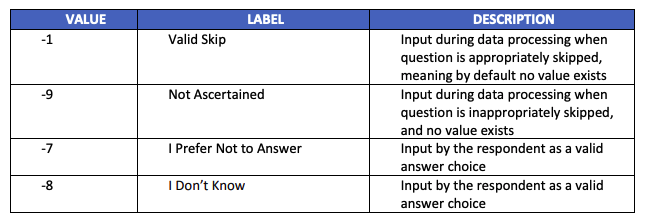

In [48]:
# Define the nonresponse codes
nonresponse_codes = [-1, -7, -8, -9]

# Initialize a dataframe to store counts
nonresponse_counts = pd.DataFrame(columns=['Column_Name', '-1', '-7', '-8', '-9'])

# Loop through each column and count nonresponse values
for col in student_trips_filtered.columns:
    counts = student_trips_filtered[col].isin(nonresponse_codes).groupby(student_trips_filtered[col]).sum()
    row = {
        'Column_Name': col,
        '-1': (student_trips_filtered[col] == -1).sum(),
        '-7': (student_trips_filtered[col] == -7).sum(),
        '-8': (student_trips_filtered[col] == -8).sum(),
        '-9': (student_trips_filtered[col] == -9).sum()
    }
    nonresponse_counts = pd.concat([nonresponse_counts, pd.DataFrame([row])], ignore_index=True)

# Show counts
nonresponse_counts

,Column_Name,-1,-7,-8,-9
0,HOUSEID,0,0,0,0
1,PERSONID,0,0,0,0
2,TRPMILES,0,0,0,3
3,GASPRICE,0,0,0,0
4,NUMADLT_TRIP,0,0,0,0
5,HOMEOWN_TRIP,0,0,0,0
6,CENSUS_D_TRIP,0,0,0,0
7,CENSUS_R_TRIP,0,0,0,0
8,HH_HISP_TRIP,0,0,0,0
9,DRVRCNT_TRIP,0,0,0,0


Drop all rows with -1 in the SCHTRN1 column, since this will be our target variable column.

Drop all rows with -9 in the TRPMILES column.

Also drop all rows with -7 in the HHFAMINC_TRIP column. We could have just replaced these entries with the column median, but these rows make up a small percentage of the dataset so it is okay to drop them instead.

In [49]:
# Drop rows where SCHTRN1 == -1 (invalid target variable)
student_trips_filtered = student_trips_filtered[student_trips_filtered['SCHTRN1'] != -1]

# Drop rows where TRPMILES = -9 (invalid mileage data)
student_trips_filtered = student_trips_filtered[student_trips_filtered['TRPMILES'] != -9]

# Drop rows where HHFAMINC_TRIP == -7 (invalid income data)
student_trips_filtered = student_trips_filtered[student_trips_filtered['HHFAMINC_TRIP'] != -7]

# Reset index after dropping rows
student_trips_filtered = student_trips_filtered.reset_index(drop=True)

# Confirm changes
print(student_trips_filtered.shape)
student_trips_filtered['SCHTRN1'].value_counts()


(4470, 26)


,count
SCHTRN1,
1,1408
9,1103
3,860
20,401
2,289
4,124
18,109
8,102
21,30


Clean up repeats, since one student may have taken multiple trips (multiple rows), including trips that are unrelated to school.

First, group any "similar" rows (rows with the same HOUSEID **and** PERSONID).

Create a new column called 'SCHOOL_DISTANCE' with blank values.

Among each group of "similar" rows, find all rows where 'WHYTO' == 6 (indicates the trip was to go to school). Take the median value for 'TRPMILES' for all of these rows and fill that value in for the 'SCHOOL_DISTANCE' column for all these rows.

If there are no rows where 'WHYTO' == 6, do nothing.

Drop the 'WHYTO', 'HOUSEID', 'PERSONID' columns.

Drop all repeat occurences of rows with the same HOUSEID and PERSONID.

For all rows with a 0 in the 'SCHOOL_DISTANCE' column, fill in with the median value of the column.

In [50]:
# Make a copy to be safe
student_trips_filtered = student_trips_filtered.copy()

# Step 1: Create a blank SCHOOL_DISTANCE column
student_trips_filtered['SCHOOL_DISTANCE'] = np.nan

# Step 2: For each (HOUSEID, PERSONID) group, fill SCHOOL_DISTANCE with the median TRPMILES where WHYTO == 6
def assign_school_distance(group):
    school_trips = group[group['WHYTO'] == 6]['TRPMILES']
    if not school_trips.empty:
        median_distance = school_trips.median()
        group['SCHOOL_DISTANCE'] = median_distance
    return group

student_trips_filtered = student_trips_filtered.groupby(['HOUSEID', 'PERSONID'], group_keys=False).apply(assign_school_distance)

# Step 3: Drop the WHYTO column
student_trips_filtered = student_trips_filtered.drop(columns=['WHYTO'])

# Step 4: Drop duplicate rows with same HOUSEID and PERSONID (keep the first)
student_trips_filtered = student_trips_filtered.drop_duplicates(subset=['HOUSEID', 'PERSONID'])

# Step 5: Fill SCHOOL_DISTANCE = 0 with the column median
median_distance = student_trips_filtered.loc[student_trips_filtered['SCHOOL_DISTANCE'] > 0, 'SCHOOL_DISTANCE'].median()
student_trips_filtered['SCHOOL_DISTANCE'] = student_trips_filtered['SCHOOL_DISTANCE'].replace(0, np.nan)
student_trips_filtered['SCHOOL_DISTANCE'] = student_trips_filtered['SCHOOL_DISTANCE'].fillna(median_distance)

#drop HOUSEID and PERSONID columns
student_trips_filtered = student_trips_filtered.drop(columns=['HOUSEID'])
student_trips_filtered = student_trips_filtered.drop(columns=['PERSONID'])

# Step 6: Reset index
student_trips_filtered = student_trips_filtered.reset_index(drop=True)

# Confirm result
print(student_trips_filtered.shape)
student_trips_filtered.head()


(1680, 24)


/tmp/ipython-input-2859156902.py:15: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  student_trips_filtered = student_trips_filtered.groupby(['HOUSEID', 'PERSONID'], group_keys=False).apply(assign_school_distance)


,TRPMILES,GASPRICE,NUMADLT_TRIP,HOMEOWN_TRIP,CENSUS_D_TRIP,CENSUS_R_TRIP,HH_HISP_TRIP,DRVRCNT_TRIP,CDIVMSAR_TRIP,HHFAMINC_TRIP,...,MSACAT_TRIP,MSASIZE_TRIP,URBAN_TRIP,URBANSIZE_TRIP,URBRUR_TRIP,SCHOOL1,HOMETYPE,YOUNGCHILD,SCHTRN1,SCHOOL_DISTANCE
0,3.902424,355.1,2,1,1,1,2,2,11,11,...,1,5,1,4,1,1,1,0,1,2.882536
1,6.073959,355.1,2,3,1,1,2,1,11,6,...,1,5,1,4,1,1,3,0,1,6.073959
2,95.208825,350.2,2,1,1,1,2,2,12,10,...,2,4,4,6,2,1,1,2,9,2.882536
3,1.351771,367.2,2,1,1,1,2,2,13,7,...,3,3,1,2,1,1,1,0,20,1.351771
4,1.403356,367.2,2,1,1,1,2,2,13,7,...,3,3,1,2,1,1,1,0,18,1.403356


Drop the TRPMILES column.

In [51]:
student_trips_filtered = student_trips_filtered.drop(columns=['TRPMILES'])

Quick check: how many unique students in our dataset usually use a school bus?

In [52]:
# Count how many students have SCHTRN1 == 9
mode_9_count = student_trips_filtered[student_trips_filtered['SCHTRN1'] == 9].shape[0]
total_students = student_trips_filtered.shape[0]

print(f"School trips with SCHTRN 9: {mode_9_count}")
print(f"Total students: {total_students}")
print(f"Percentage: {mode_9_count / total_students * 100:.2f}%")


School trips with SCHTRN 9: 440
Total students: 1680
Percentage: 26.19%


Re encode the SCHTRN1 column to a binary NEEDS_SCHOOL_BUS column. Code 9 indicates the student usually takes a bus to school, and all other codes indicate other means of transport.

**Limitation Note: This process assumes that every student who uses a school bus needs a school bus, and that if a student doesn't usually use a bus they do not need a bus. This is not always correct in practice, since many students might not use a bus because of bad bus service, even if they actually need it. Future changes to address this limitation might be to more carefully analyze what other modes of transport students use and for how many miles to help determine which students NEED a bus vs actually USE a bus.**

In [53]:
# Re-encode the SCHTRN1 column to indicate "needs school bus"
# Original column: SCHTRN1
# Rule: 9 → 1 (needs school bus), everything else → 0

student_trips_filtered['NEEDS_SCHOOL_BUS'] = student_trips_filtered['SCHTRN1'].apply(lambda x: 1 if x == 9 else 0)

# Optional: drop the original TRPTRANS column if no longer needed
student_trips_filtered = student_trips_filtered.drop(columns=['SCHTRN1'])

# Verify changes
student_trips_filtered[['NEEDS_SCHOOL_BUS']].head(30)

,NEEDS_SCHOOL_BUS
0,0
1,0
2,1
3,0
4,0
5,0
6,0
7,1
8,1
9,0


**One Hot Encoding**

First, download the codebook.xlsx file and load it in. This codebook contains mappings for every code used for all categorical variables, as well as for some numerical variables.

In [54]:
codebook_df = pd.read_excel('codebook.xlsx')
codebook_df.head()

,Name,Label,Type,Length,Code / Range,Frequency,Weighted
0,CDIVMSAR,Grouping of household by combination of Census...,C,2.0,11=New England MSA/CMSA of 1 million+ with hea...,161,2.066163e+06
1,NaN,NaN,NaN,NaN,12=New England MSA/CMSA of 1 million+ w/o heav...,51,7.035232e+05
2,NaN,NaN,NaN,NaN,13=New England MSA of less than 1 million,208,3.135078e+06
3,NaN,NaN,NaN,NaN,14=New England Not in an MSA,19,2.219983e+05
4,NaN,NaN,NaN,NaN,21=Mid-Atlantic MSA/CMSA of 1 million+ with he...,468,8.330759e+06


Forward fill the variable names so that each code is associated with a column variable name.

In [55]:
# Forward fill the 'Name' column so each code row knows its variable
codebook_df['Name'] = codebook_df['Name'].ffill()
codebook_df.head()

,Name,Label,Type,Length,Code / Range,Frequency,Weighted
0,CDIVMSAR,Grouping of household by combination of Census...,C,2.0,11=New England MSA/CMSA of 1 million+ with hea...,161,2.066163e+06
1,CDIVMSAR,NaN,NaN,NaN,12=New England MSA/CMSA of 1 million+ w/o heav...,51,7.035232e+05
2,CDIVMSAR,NaN,NaN,NaN,13=New England MSA of less than 1 million,208,3.135078e+06
3,CDIVMSAR,NaN,NaN,NaN,14=New England Not in an MSA,19,2.219983e+05
4,CDIVMSAR,NaN,NaN,NaN,21=Mid-Atlantic MSA/CMSA of 1 million+ with he...,468,8.330759e+06


Keep only the Name and Code / Range columns.

Our student_trips_filtered dataframe has column names based on the TRIPS file, which has _TRIPS appended to most of the column names. Clean up the column names in student_trips_filtered so they match the names in the codebook.

Filter the codebook so that only codes for variables actually present in our dataframe are preserved.

In [56]:
# Step 2: Keep only the relevant columns
codebook_df = codebook_df[['Name', 'Code / Range']]

# Step 3: Get your dataset’s column names
school_trip_cols = student_trips_filtered.columns

# Step 4: Clean up names to match between codebook and your df
# The codebook may use names like 'HHFAMINC' while your df uses 'HHFAMINC_TRIP'
# So we match ignoring trailing suffixes like '_TRIP'
base_names = [c.replace('_TRIP', '') for c in school_trip_cols]

# Step 5: Filter the codebook so we only keep rows whose Name matches one of these
filtered_codebook = codebook_df[codebook_df['Name'].isin(base_names)].copy()

# Step 6: Display the first few rows to confirm
filtered_codebook.head(20)

,Name,Code / Range
0,CDIVMSAR,11=New England MSA/CMSA of 1 million+ with hea...
1,CDIVMSAR,12=New England MSA/CMSA of 1 million+ w/o heav...
2,CDIVMSAR,13=New England MSA of less than 1 million
3,CDIVMSAR,14=New England Not in an MSA
4,CDIVMSAR,21=Mid-Atlantic MSA/CMSA of 1 million+ with he...
5,CDIVMSAR,22=Mid-Atlantic MSA/CMSA of 1 million+ w/o hea...
6,CDIVMSAR,23=Mid-Atlantic MSA of less than 1 million
7,CDIVMSAR,24=Mid-Atlantic Not in an MSA
8,CDIVMSAR,31=East North Central MSA/CMSA of 1 million+ w...
9,CDIVMSAR,32=East North Central MSA/CMSA of 1 million+ w...


Several numerical variable columns are still listed in the codebook dataframe, so we should remove them.

In [57]:
# list of non-categorical variables to drop
non_categorical = ['DRVRCNT', 'HHFAMINC_IMP', 'HHSIZE', 'HHVEHCNT', 'NUMADLT', 'YOUNGCHILD']

# Remove these from the codebook subset
codebook_df = codebook_df[~codebook_df['Name'].isin(non_categorical)]

# Confirm the filtered codebook
codebook_df.head()


,Name,Code / Range
0,CDIVMSAR,11=New England MSA/CMSA of 1 million+ with hea...
1,CDIVMSAR,12=New England MSA/CMSA of 1 million+ w/o heav...
2,CDIVMSAR,13=New England MSA of less than 1 million
3,CDIVMSAR,14=New England Not in an MSA
4,CDIVMSAR,21=Mid-Atlantic MSA/CMSA of 1 million+ with he...


Remove the _TRIP suffix from all columns in student_trips_filtered that have the suffix.

In [58]:
# Remove '_TRIP' suffix from all column names
student_trips_filtered.columns = [col.replace('_TRIP', '') for col in student_trips_filtered.columns]
student_trips_filtered.head()

,GASPRICE,NUMADLT,HOMEOWN,CENSUS_D,CENSUS_R,HH_HISP,DRVRCNT,CDIVMSAR,HHFAMINC,HH_RACE,...,MSACAT,MSASIZE,URBAN,URBANSIZE,URBRUR,SCHOOL1,HOMETYPE,YOUNGCHILD,SCHOOL_DISTANCE,NEEDS_SCHOOL_BUS
0,355.1,2,1,1,1,2,2,11,11,1,...,1,5,1,4,1,1,1,0,2.882536,0
1,355.1,2,3,1,1,2,1,11,6,1,...,1,5,1,4,1,1,3,0,6.073959,0
2,350.2,2,1,1,1,2,2,12,10,1,...,2,4,4,6,2,1,1,2,2.882536,1
3,367.2,2,1,1,1,2,2,13,7,1,...,3,3,1,2,1,1,1,0,1.351771,0
4,367.2,2,1,1,1,2,2,13,7,1,...,3,3,1,2,1,1,1,0,1.403356,0


To one hot encode, we can create a mapping dictionary that maps integer codes present in each column of student_trips_filtered to their corresponding "human readable column names" in the codebook dataframe.

Keep in mind that the numerical codes in the codebook dataframe appear as strings, but are integer entries in  student_trips_filtered, so str->int conversion is needed to match them.

Finally, we can use pd.get_dummies to one hot encode all the categorical columns, rewriting the auto-generated column names to the human readable versions using the mapping dictionary.

In [59]:
# Step 1: Build mapping dictionary
mapping_dict = {}
for var in codebook_df['Name'].unique():
    subset = codebook_df[codebook_df['Name'] == var]['Code / Range'].dropna()
    var_map = {}
    for entry in subset:
        if '=' in entry:
            code, label = entry.split('=', 1)
            try:
                var_map[int(code.strip())] = label.strip()
            except ValueError:
                var_map[code.strip()] = label.strip()
    mapping_dict[var] = var_map

# Step 2: Convert categorical columns to int where possible
for col in mapping_dict.keys():
    if col in student_trips_filtered.columns:
        try:
            student_trips_filtered[col] = student_trips_filtered[col].astype(int)
        except ValueError:
            pass

# Step 3: Identify categorical vars (binary or not)
categorical_vars = [col for col in mapping_dict.keys() if col in student_trips_filtered.columns]

# Step 4: One-hot encode while dropping one dummy per variable to avoid multicollinearity
onehot_df = pd.get_dummies(
    student_trips_filtered,
    columns=categorical_vars,
    prefix=categorical_vars,
    dtype=int,
    drop_first=True
)

# Step 5: Rename one-hot columns to human-readable labels
new_columns = []
for col in onehot_df.columns:
    matched = False
    for var, code_map in mapping_dict.items():
        for code, label in code_map.items():
            if col == f"{var}_{code}":
                new_columns.append(f"{var}_{label}")
                matched = True
                break
        if matched:
            break
    if not matched:
        new_columns.append(col)

onehot_df.columns = new_columns

onehot_df.head()



,GASPRICE,NUMADLT,DRVRCNT,HHSIZE,HHVEHCNT,SCHOOL1,YOUNGCHILD,SCHOOL_DISTANCE,NEEDS_SCHOOL_BUS,CDIVMSAR_New England MSA/CMSA of 1 million+ w/o heavy rail,...,MSASIZE_In an MSA or CMSA of 3 million or more,MSASIZE_Not in MSA or CMSA,URBAN_In an Urban cluster,URBAN_Not in urban area,"URBANSIZE_200,000-499,999","URBANSIZE_500,000-999,999","URBANSIZE_1,000,000 or more with heavy rail","URBANSIZE_1,000,000 or more without heavy rail",URBANSIZE_Not in urbanized area,URBRUR_Rural
0,355.1,2,2,4,2,1,0,2.882536,0,0,...,1,0,0,0,0,0,1,0,0,0
1,355.1,2,1,2,1,1,0,6.073959,0,0,...,1,0,0,0,0,0,1,0,0,0
2,350.2,2,2,5,2,1,2,2.882536,1,1,...,0,0,0,1,0,0,0,0,1,1
3,367.2,2,2,6,2,1,0,1.351771,0,0,...,0,0,0,0,1,0,0,0,0,0
4,367.2,2,2,6,2,1,0,1.403356,0,0,...,0,0,0,0,1,0,0,0,0,0


Verify the one hot encoding and renaming.

In [60]:
# Get the dimensions
print("Shape of the one-hot encoded dataframe:", onehot_df.shape)

# Print all column names neatly
print("Columns:")
for col in onehot_df.columns:
    print(col)


Shape of the one-hot encoded dataframe: (1680, 99)
Columns:
GASPRICE
NUMADLT
DRVRCNT
HHSIZE
HHVEHCNT
SCHOOL1
YOUNGCHILD
SCHOOL_DISTANCE
NEEDS_SCHOOL_BUS
CDIVMSAR_New England MSA/CMSA of 1 million+ w/o heavy rail
CDIVMSAR_New England MSA of less than 1 million
CDIVMSAR_New England Not in an MSA
CDIVMSAR_Mid-Atlantic MSA/CMSA of 1 million+ with heavy rail
CDIVMSAR_Mid-Atlantic MSA/CMSA of 1 million+ w/o heavy rail
CDIVMSAR_Mid-Atlantic MSA of less than 1 million
CDIVMSAR_Mid-Atlantic Not in an MSA
CDIVMSAR_East North Central MSA/CMSA of 1 million+ with heavy rail
CDIVMSAR_East North Central MSA/CMSA of 1 million+ w/o heavy rail
CDIVMSAR_East North Central MSA of less than 1 million
CDIVMSAR_East North Central Not in an MSA
CDIVMSAR_West North Central MSA/CMSA of 1 million+ w/o heavy rail
CDIVMSAR_West North Central MSA of less than 1 million
CDIVMSAR_West North Central Not in an MSA
CDIVMSAR_South Atlantic MSA/CMSA of 1 million+ with heavy rail
CDIVMSAR_South Atlantic MSA/CMSA of 1 milli

Drop the SCHOOL1 column (forgot to do this earlier).


In [61]:
onehot_df = onehot_df.drop(columns=['SCHOOL1'])

Make a correlation matrix.

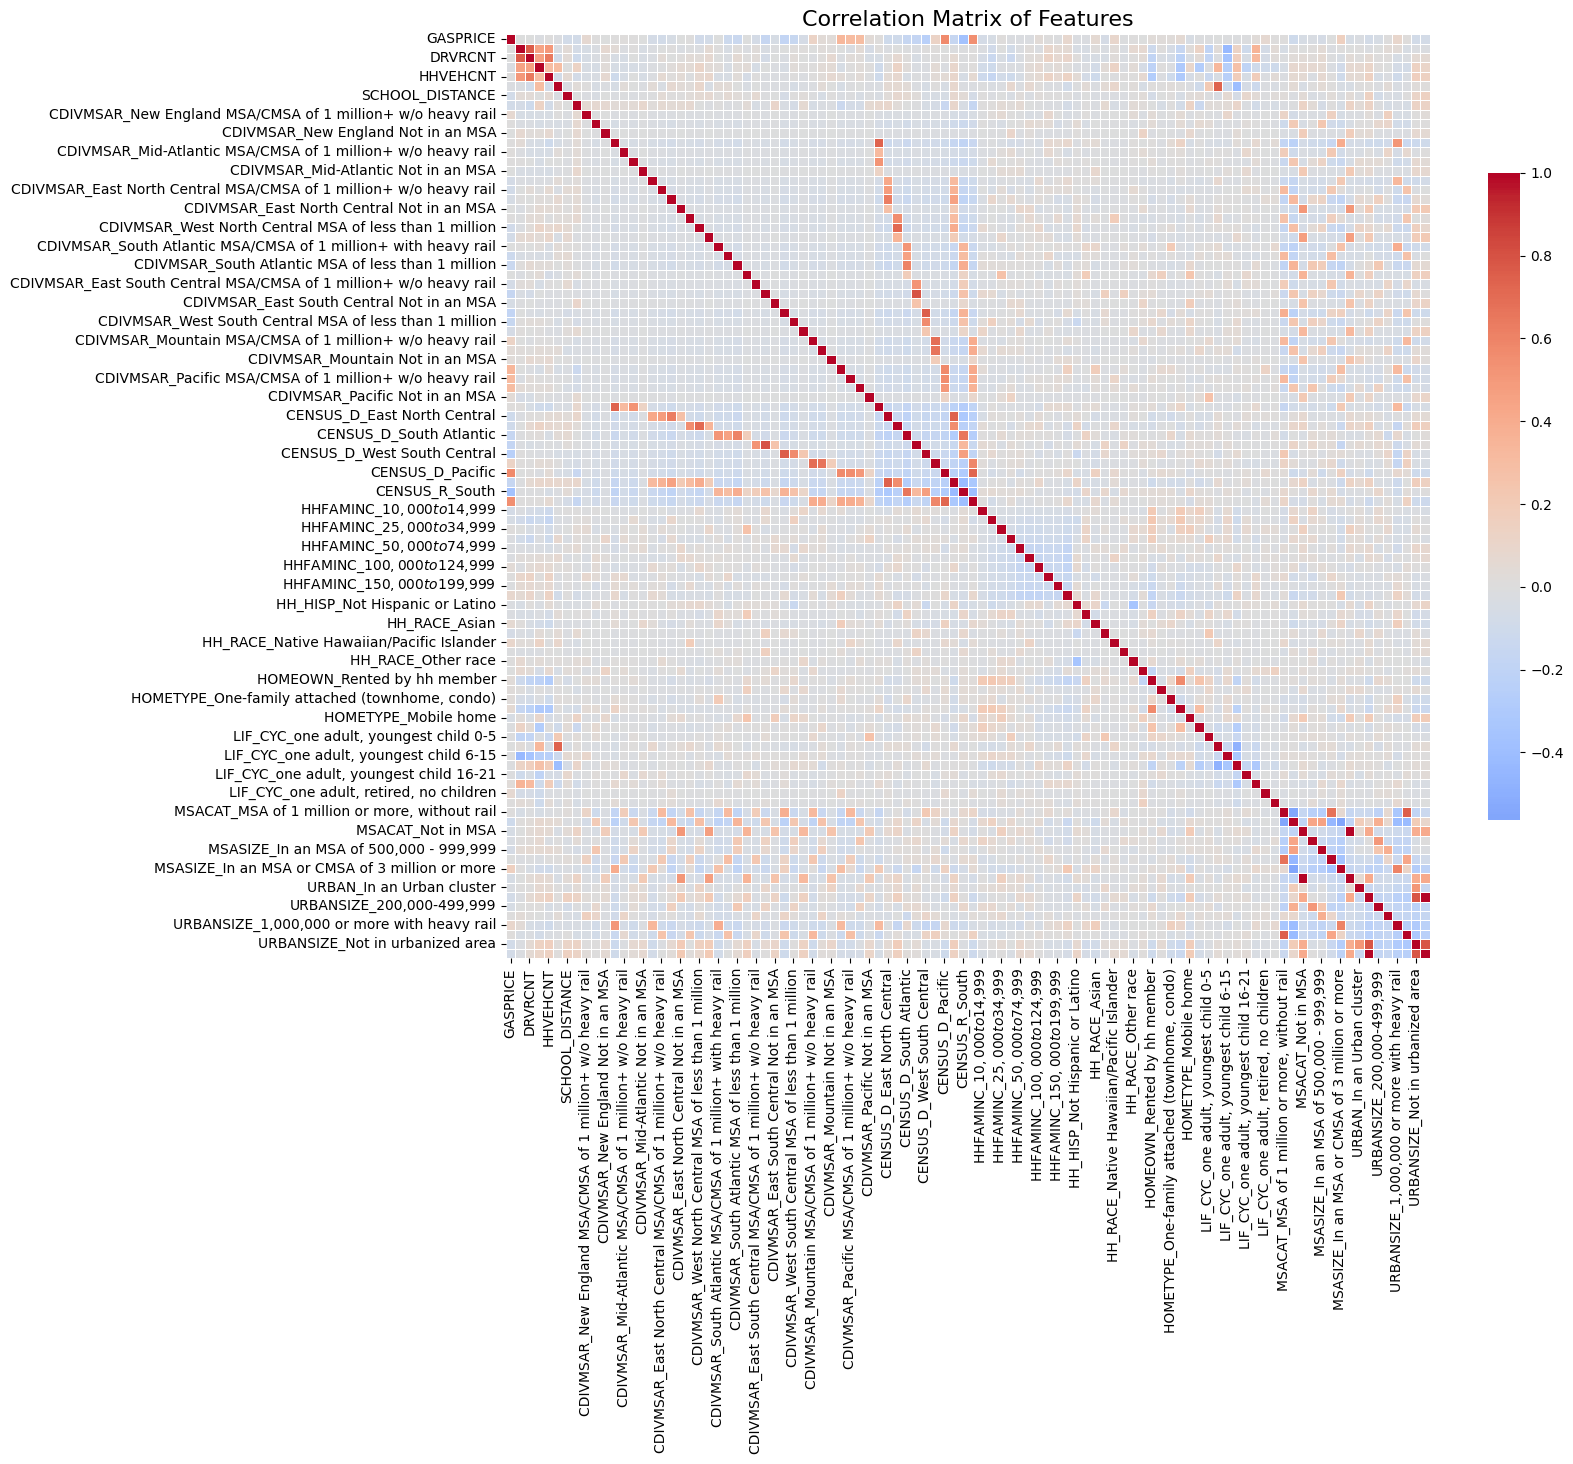

In [62]:
import matplotlib.pyplot as plt
import seaborn as sns

# Compute correlation matrix
corr_matrix = onehot_df.corr()

# Set up the matplotlib figure
plt.figure(figsize=(15, 12))

# Draw the heatmap
sns.heatmap(corr_matrix,
            cmap='coolwarm',
            center=0,
            annot=False,  # True if you want the numbers on the heatmap
            fmt=".2f",
            square=True,
            linewidths=0.5,
            cbar_kws={"shrink": 0.7})

plt.title("Correlation Matrix of Features", fontsize=16)
plt.show()


**Further Cleanup of Features**

Make boxplots of numerical values to catch outliers.

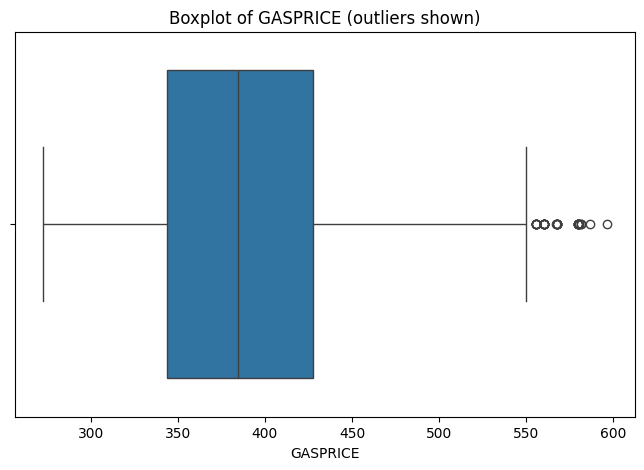

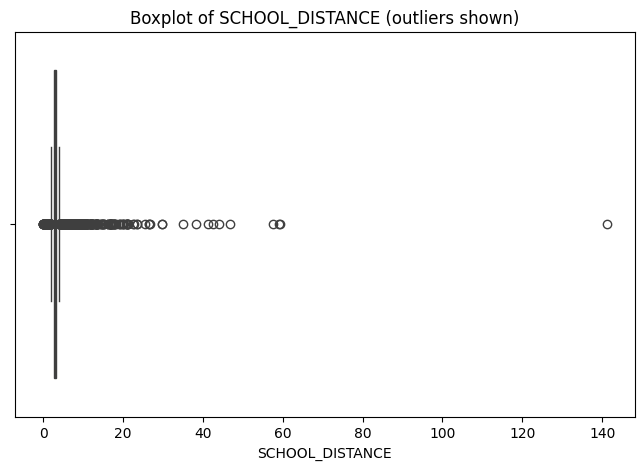

In [63]:
import matplotlib.pyplot as plt
import seaborn as sns

# List of numerical variables
numerical_vars = [
    'GASPRICE', 'SCHOOL_DISTANCE'
]

# Loop through each variable and create a boxplot
for var in numerical_vars:
    plt.figure(figsize=(8, 5))
    sns.boxplot(x=onehot_df[var])
    plt.title(f'Boxplot of {var} (outliers shown)')
    plt.xlabel(var)
    plt.show()


Let's figure out how many outliers we need to get rid of.

In [64]:
def count_outliers(series):
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR
    outliers = series[(series < lower) | (series > upper)]
    return len(outliers), len(outliers) / len(series) * 100

for var in ['GASPRICE', 'SCHOOL_DISTANCE']:
    count, percent = count_outliers(onehot_df[var])
    print(f"{var}: {count} outliers ({percent:.2f}% of total entries)")


GASPRICE: 35 outliers (2.08% of total entries)
SCHOOL_DISTANCE: 663 outliers (39.46% of total entries)


We can leave the outliers for gas price as is, but we need to take care of the outliers for school distance. Let's visualize the breakdown of school bus users.

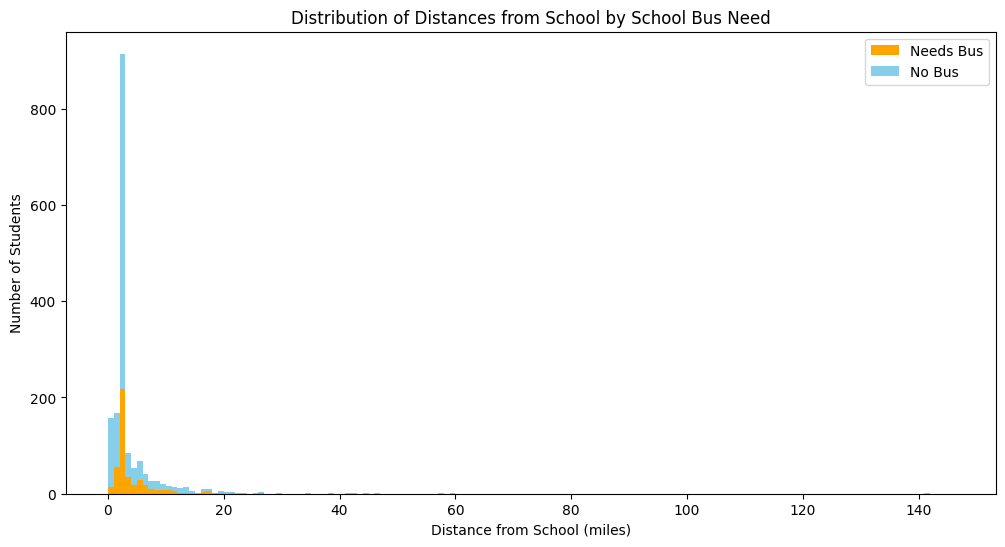

In [65]:
import matplotlib.pyplot as plt
import numpy as np

# Define bins every 5 miles
max_distance = student_trips_filtered['SCHOOL_DISTANCE'].max()
bins = np.arange(0, max_distance + 5, 1)

# Split distances by NEED_SCHOOL_BUS
distance_bus = student_trips_filtered[student_trips_filtered['NEEDS_SCHOOL_BUS'] == 1]['SCHOOL_DISTANCE']
distance_no_bus = student_trips_filtered[student_trips_filtered['NEEDS_SCHOOL_BUS'] == 0]['SCHOOL_DISTANCE']

# Plot stacked histogram
plt.figure(figsize=(12,6))
plt.hist([distance_bus, distance_no_bus], bins=bins, stacked=True, color=['orange', 'skyblue'], label=['Needs Bus', 'No Bus'])
plt.xlabel('Distance from School (miles)')
plt.ylabel('Number of Students')
plt.title('Distribution of Distances from School by School Bus Need')
plt.legend()
plt.show()


Let's analyze just the outliers.

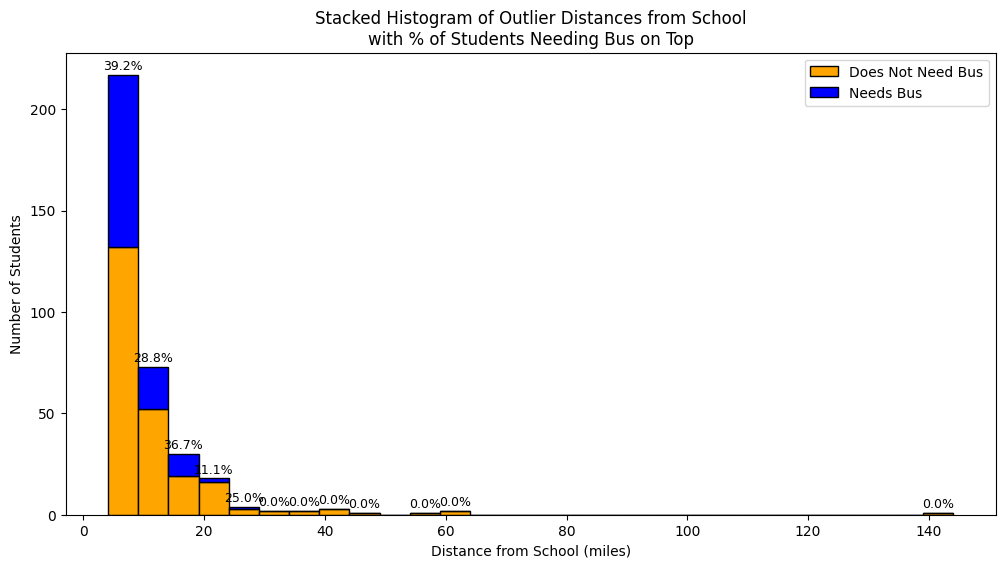

In [66]:
import numpy as np
import matplotlib.pyplot as plt

# Identify outliers using 1.5*IQR
Q1 = student_trips_filtered['SCHOOL_DISTANCE'].quantile(0.25)
Q3 = student_trips_filtered['SCHOOL_DISTANCE'].quantile(0.75)
IQR = Q3 - Q1
outliers = student_trips_filtered[student_trips_filtered['SCHOOL_DISTANCE'] > Q3 + 1.5*IQR]

# Define bins
bins = np.arange(outliers['SCHOOL_DISTANCE'].min(), outliers['SCHOOL_DISTANCE'].max() + 5, 5)

# Compute counts per bin
counts_bus1, _ = np.histogram(outliers[outliers['NEEDS_SCHOOL_BUS']==1]['SCHOOL_DISTANCE'], bins=bins)
counts_bus0, _ = np.histogram(outliers[outliers['NEEDS_SCHOOL_BUS']==0]['SCHOOL_DISTANCE'], bins=bins)
counts_total = counts_bus1 + counts_bus0

# Plot stacked histogram
plt.figure(figsize=(12,6))
plt.bar(bins[:-1], counts_bus0, width=5, color='orange', label='Does Not Need Bus', align='edge', edgecolor='black')
plt.bar(bins[:-1], counts_bus1, width=5, bottom=counts_bus0, color='blue', label='Needs Bus', align='edge', edgecolor='black')

# Add percent labels
for i in range(len(bins)-1):
    if counts_total[i] > 0:
        pct = counts_bus1[i] / counts_total[i] * 100
        plt.text(bins[i] + 2.5, counts_total[i] + 1, f'{pct:.1f}%', ha='center', va='bottom', fontsize=9)

plt.xlabel('Distance from School (miles)')
plt.ylabel('Number of Students')
plt.title('Stacked Histogram of Outlier Distances from School\nwith % of Students Needing Bus on Top')
plt.legend()
plt.show()


Filter out all outliers above 30 miles of distance from school since 0% of these students used a bus (likely edge cases and unrepresentative trips).

In [67]:
# Remove rows where SCHOOL_DISTANCE > 30 miles
student_trips_filtered = student_trips_filtered[student_trips_filtered['SCHOOL_DISTANCE'] <= 30].reset_index(drop=True)


Many schools have a "minimum distance" policy for school bus users.

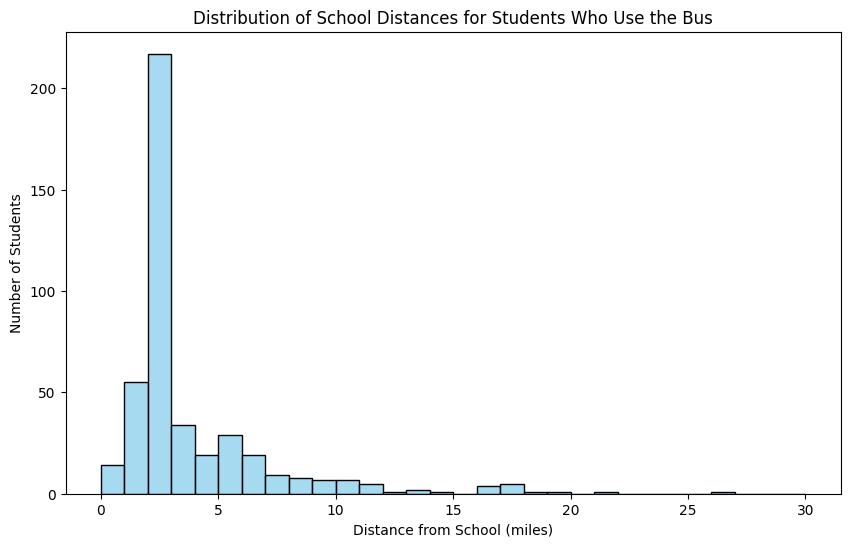

In [68]:
import matplotlib.pyplot as plt
import seaborn as sns

# Filter to students who need a bus
bus_students = student_trips_filtered[student_trips_filtered['NEEDS_SCHOOL_BUS'] == 1]

# Plot histogram
plt.figure(figsize=(10,6))
sns.histplot(bus_students['SCHOOL_DISTANCE'], bins=range(0, int(bus_students['SCHOOL_DISTANCE'].max()) + 5, 1),
             kde=False, color='skyblue', edgecolor='black')
plt.title('Distribution of School Distances for Students Who Use the Bus')
plt.xlabel('Distance from School (miles)')
plt.ylabel('Number of Students')
plt.xticks(range(0, int(bus_students['SCHOOL_DISTANCE'].max()) + 5, 5))
plt.show()


Since there is no known standard minimum distance that we can filter by, it is best to keep all the entries of students. The model will learn that students closer to school do not need a bus (usually because policy dictates that they don't).

Now we need to reduce some more columns based on feasibility. A good started is the heavy rail distinction placed on most categories; this is both infeasible to acquire and not very useful.

In [69]:
import re #not really needed

# For CDIVMSAR: merge "+ w/o heavy rail" and "+ with heavy rail" variants
cd_cols = [col for col in onehot_df.columns if col.startswith('CDIVMSAR')]
cd_base_names = set([re.sub(r'\+.*heavy rail', '', col) for col in cd_cols])

for base in cd_base_names:
    matching_cols = [col for col in cd_cols if col.startswith(base)]
    onehot_df[base] = onehot_df[matching_cols].sum(axis=1)
    onehot_df[base] = (onehot_df[base] > 0).astype(int)
    onehot_df.drop(columns=matching_cols, inplace=True)

# For URBANSIZE: merge " with heavy rail" and " without heavy rail" variants
urb_cols = [col for col in onehot_df.columns if col.startswith('URBANSIZE')]
urb_base_names = set([re.sub(r'\s*(with|without).*heavy rail', '', col, flags=re.IGNORECASE) for col in urb_cols])

for base in urb_base_names:
    matching_cols = [col for col in urb_cols if col.startswith(base)]
    onehot_df[base] = onehot_df[matching_cols].sum(axis=1)
    onehot_df[base] = (onehot_df[base] > 0).astype(int)
    onehot_df.drop(columns=matching_cols, inplace=True)

# Check updated columns
onehot_df.columns


Index(['GASPRICE', 'NUMADLT', 'DRVRCNT', 'HHSIZE', 'HHVEHCNT', 'YOUNGCHILD',
       'SCHOOL_DISTANCE', 'NEEDS_SCHOOL_BUS', 'CENSUS_D_Middle Atlantic',
       'CENSUS_D_East North Central', 'CENSUS_D_West North Central',
       'CENSUS_D_South Atlantic', 'CENSUS_D_East South Central',
       'CENSUS_D_West South Central', 'CENSUS_D_Mountain', 'CENSUS_D_Pacific',
       'CENSUS_R_Midwest', 'CENSUS_R_South', 'CENSUS_R_West',
       'HHFAMINC_$10,000 to $14,999', 'HHFAMINC_$15,000 to $24,999',
       'HHFAMINC_$25,000 to $34,999', 'HHFAMINC_$35,000 to $49,999',
       'HHFAMINC_$50,000 to $74,999', 'HHFAMINC_$75,000 to $99,999',
       'HHFAMINC_$100,000 to $124,999', 'HHFAMINC_$125,000 to $149,999',
       'HHFAMINC_$150,000 to $199,999', 'HHFAMINC_$200,000 or more',
       'HH_HISP_Not Hispanic or Latino', 'HH_RACE_Black or African American',
       'HH_RACE_Asian', 'HH_RACE_American Indian/Alaska Native',
       'HH_RACE_Native Hawaiian/Pacific Islander',
       'HH_RACE_Multiple races 

Let's also drop Life Cycle, NUMADLT, DRVRCNT, HHSIZE, HHVEHCNT, YOUNGCHILD; although these are likely strong predictors, we cannot feasibly acquire this data for a student.

We can also acquire data on whether or not a house is a mobile home, but not reliabely more specific than that, so let us merge the hometype columns into mobile home vs not mobile home.

In [70]:
# Columns to drop completely
cols_to_drop = [
    'LIF_CYC_2+ adults, no children',
    'LIF_CYC_one adult, youngest child 0-5',
    'LIF_CYC_2+ adults, youngest child 0-5',
    'LIF_CYC_one adult, youngest child 6-15',
    'LIF_CYC_2+ adults, youngest child 6-15',
    'LIF_CYC_one adult, youngest child 16-21',
    'LIF_CYC_2+ adults, youngest child 16-21',
    'LIF_CYC_one adult, retired, no children',
    'LIF_CYC_2+ adults, retired, no children',
    'HOMEOWN_Owned by hh member free and clear (no mortgage)',
    'HOMEOWN_Rented by hh member',
    'HOMEOWN_Occupied without payment',
    'NUMADLT',
    'DRVRCNT',
    'HHSIZE',
    'HHVEHCNT',
    'YOUNGCHILD'
]

# Drop these columns
onehot_df = onehot_df.drop(columns=cols_to_drop)

# Condense HOMETYPE into mobile home vs not mobile home
mobile_home_cols = ['HOMETYPE_Mobile home']
other_home_cols = [
    'HOMETYPE_One-family attached (townhome, condo)',
    'HOMETYPE_Building with 2 or more apartments'
]

# Create a new column 'HOMETYPE_MobileHome'
onehot_df['HOMETYPE_MobileHome'] = onehot_df[mobile_home_cols].copy()
# Drop the original HOMETYPE columns
onehot_df = onehot_df.drop(columns=mobile_home_cols + other_home_cols)


Remove highly correlated columns.

In [71]:
# Step 1: Compute correlation matrix for all numeric columns
corr_matrix = onehot_df.corr().abs()  # absolute correlation

# Step 2: Create an upper triangle mask so we don't consider duplicate pairs
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Step 3: Find columns with correlation greater than threshold
threshold = 0.9
to_drop = [col for col in upper_tri.columns if any(upper_tri[col] > threshold)]

print(f"Columns to drop due to high correlation (> {threshold}):")
print(to_drop)

# Step 4: Drop these columns
onehot_df_reduced = onehot_df.drop(columns=to_drop)

print(f"Shape before dropping: {onehot_df.shape}")
print(f"Shape after dropping: {onehot_df_reduced.shape}")

Columns to drop due to high correlation (> 0.9):
['MSASIZE_Not in MSA or CMSA', 'URBRUR_Rural']
Shape before dropping: (1680, 53)
Shape after dropping: (1680, 51)


In [72]:
onehot_df.columns

Index(['GASPRICE', 'SCHOOL_DISTANCE', 'NEEDS_SCHOOL_BUS',
       'CENSUS_D_Middle Atlantic', 'CENSUS_D_East North Central',
       'CENSUS_D_West North Central', 'CENSUS_D_South Atlantic',
       'CENSUS_D_East South Central', 'CENSUS_D_West South Central',
       'CENSUS_D_Mountain', 'CENSUS_D_Pacific', 'CENSUS_R_Midwest',
       'CENSUS_R_South', 'CENSUS_R_West', 'HHFAMINC_$10,000 to $14,999',
       'HHFAMINC_$15,000 to $24,999', 'HHFAMINC_$25,000 to $34,999',
       'HHFAMINC_$35,000 to $49,999', 'HHFAMINC_$50,000 to $74,999',
       'HHFAMINC_$75,000 to $99,999', 'HHFAMINC_$100,000 to $124,999',
       'HHFAMINC_$125,000 to $149,999', 'HHFAMINC_$150,000 to $199,999',
       'HHFAMINC_$200,000 or more', 'HH_HISP_Not Hispanic or Latino',
       'HH_RACE_Black or African American', 'HH_RACE_Asian',
       'HH_RACE_American Indian/Alaska Native',
       'HH_RACE_Native Hawaiian/Pacific Islander',
       'HH_RACE_Multiple races selected', 'HH_RACE_Other race',
       'MSACAT_MSA of 1 m

In [73]:
# Save the dataframe as CSV
onehot_df.to_csv('2022_OneHot_V2.csv', index=False)

from google.colab import files

files.download('2022_OneHot_V2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

Experiment w/ logistic regression for future.

In [74]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# 1️⃣ Define target and features
X = onehot_df.drop(columns=['NEEDS_SCHOOL_BUS'])
y = onehot_df['NEEDS_SCHOOL_BUS']

# 2️⃣ Split data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 3️⃣ Create pipeline
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # scales all numeric features
    ('logreg', LogisticRegression(max_iter=1000, class_weight='balanced'))
])

# 4️⃣ Fit model
pipeline.fit(X_train, y_train)

# 5️⃣ Predict
y_pred = pipeline.predict(X_test)
y_proba = pipeline.predict_proba(X_test)[:,1]

# 6️⃣ Evaluate
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_score = roc_auc_score(y_test, y_proba)
print(f"\nROC AUC Score: {roc_score:.3f}")


Confusion Matrix:
[[143 105]
 [ 39  49]]

Classification Report:
              precision    recall  f1-score   support

           0       0.79      0.58      0.67       248
           1       0.32      0.56      0.40        88

    accuracy                           0.57       336
   macro avg       0.55      0.57      0.54       336
weighted avg       0.66      0.57      0.60       336


ROC AUC Score: 0.617


Experiment with random forest for future.

In [75]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score

# Step 1: Split features and target
X = onehot_df.drop(columns=['NEEDS_SCHOOL_BUS'])
y = onehot_df['NEEDS_SCHOOL_BUS']

# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Step 3: Initialize Random Forest
rf = RandomForestClassifier(
    n_estimators=200,      # number of trees
    max_depth=None,        # allow full depth
    random_state=42,
    class_weight='balanced'  # handles class imbalance
)

# Step 4: Fit model
rf.fit(X_train, y_train)

# Step 5: Predictions
y_pred = rf.predict(X_test)
y_proba = rf.predict_proba(X_test)[:,1]  # probability for ROC AUC

# Step 6: Evaluation
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_proba))


Confusion Matrix:
[[241   7]
 [ 47  41]]

Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.97      0.90       248
           1       0.85      0.47      0.60        88

    accuracy                           0.84       336
   macro avg       0.85      0.72      0.75       336
weighted avg       0.84      0.84      0.82       336

ROC AUC Score: 0.7667934384164223
